In [1]:
# install the necessary packages
!pip install cpmpy
!pip install gurobipy
!pip install pandas matplotlib plotly geopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.7/120.7 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 70.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.6/311.6 kB 28.9 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.14.0 requires protobuf<4.21,>=3.20.3, but you have protobuf 4.24.4 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 17.2 MB/s eta 0:00:00


In [2]:
# import the packages that we will use
from cpmpy import *
from cpmpy.solvers import CPM_gurobi, param_combinations
import gurobipy
import numpy as np
import math
import random
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px # for plotting on a map
from geopy import distance # for the distance between GPS coordinates
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [3]:
# set the random seeds for both the Python random number generator and Numpy's;
# this ensures results are reproducible if you rerun the notebook from scratch
random.seed(1)
np.random.seed(1)

Define the CPMpy model; we're using a Vehicle Routing Problem here. In principle, this can be any model.

In [4]:
# https://github.com/CPMpy/cpmpy/blob/master/examples/vrp.py

"""
In the Vehicle Routing Problem (VRP), the goal is to find
a closed path of minimal length
for a fleet of vehicles (with a capacity for each) visiting a set of locations.
If there's only 1 vehicle it reduces to the TSP. Here, each node but the depot
has an integer demand.
"""
# an integer linear programming model for the Capacitated Vehicle Routing Problem;
# You do not need to modify this.
def model_vrp(distance_matrix, n_vehicle, capacity, demand):
    n_city = distance_matrix.shape[0]

    # x[i,j] = 1 means that a vehicle goes from node i to node j
    x = intvar(0, 1, shape=distance_matrix.shape)
    # y[i,j] is a flow of load through arc (i,j)
    y = intvar(0, capacity, shape=distance_matrix.shape)

    model = Model(
        # constraint on number of vehicles (from depot, which is assumed to be node 0)
        sum(x[0,:]) == n_vehicle,
        # vehicle leaves and enter each node i exactly once
        [sum(x[i,:])==1 for i in range(1,n_city)],
        [sum(x[:,i])==1 for i in range(1,n_city)],
        # no self visits
        [sum(x[i,i] for i in range(n_city))==0],

        # from depot (which is assumed to be node 0) takes no load
        sum(y[0,:]) == 0,
        # flow out of node i through all outgoing arcs is equal to
        # flow into node i through all ingoing arcs + load capacity @ node i
        [sum(y[i,:])==sum(y[:,i])+demand[i] for i in range(1,n_city)],
    )

    # capacity constraint at each node (conditional on visit)
    for i in range(n_city):
        for j in range(n_city):
            model += y[i,j] <= capacity*x[i,j]

    # the objective is to minimze the travelled distance
    # sum(x*dist) does not work because 2D array, use .sum()
    model.minimize((x*distance_matrix).sum())

    return model, x

We define some helper functions for calculating distances and visualizing solutions.

In [5]:
# vizualize stops on map
def visualize_map_points(lats, lons):
    df_pt = pd.DataFrame({'lat': lats, 'lon': lons, 'size': 3})

    fig = px.scatter_mapbox(df_pt, lat="lat", lon="lon", size='size')
    fig.update_layout(mapbox_style="stamen-terrain", mapbox_zoom=12.8,
                      mapbox_center_lat = df_pt.iloc[0,0], mapbox_center_lon = df_pt.iloc[0,1])
    fig.show()

# distances from lat/lon to meters (rounded to the meter, so integer, great!)
def latlon_distance_matrix(lats, lons):
    coords = list(zip(lats, lons))
    return np.round([[distance.distance(p1,p2).m for p2 in coords] for p1 in coords]).astype(int)

# decode the solution matrix 'x', x[i,j] = 1 means that a vehicle goes from node i to node j
# to route sequences, in a dataframe
def decode_x(sol, lats, lons):
    data = [] # (route, seq, lat, lon)
    firsts = np.where(sol[0]==1)[0]
    for r in range(len(firsts)):
        s = 0
        idx = 0
        data.append((r, s, lats[idx], lons[idx]))
        s += 1
        idx = firsts[r]
        while (idx != 0):
            data.append((r, s, lats[idx], lons[idx]))
            # find where this idx is pointing to
            s += 1
            idx = np.where(sol[idx]==1)[0][0]
        # actually add depot at end too
        data.append((r, s, lats[idx], lons[idx]))
    return pd.DataFrame(data, columns=['route','seq','lat','lon'])

# vizualize routes on map
def visualize_map_routes(routes):
    # routes = dataframe with columns=['route','seq','lat','lon']
    fig = px.line_mapbox(routes, lat="lat", lon="lon", color="route")#, zoom=12)#, height=300)

    fig.update_traces(line=dict(width=4))
    fig.update_layout(mapbox_style="stamen-terrain", mapbox_zoom=12.8,
                      mapbox_center_lat = routes.iloc[0,2], mapbox_center_lon = routes.iloc[0,3])

    fig.show()

This function generates a set of n_locations in a rectangular area centered around the Galbraith Building and returns the matrix of pairwise distances and the coordinates.

In [6]:
def generate_locations(n_locations):
  # Let us generate some GPS coordinates around Galbraith Building randomly
  l_lat, l_lon = 43.6598852, -79.3989274
  offset_lat, offset_lon = 0.01, 0.025

  # randomly generate and add depot at beginning
  lats = l_lat + np.round(np.random.rand(n_locations-1)*2*offset_lat - offset_lat, 6)
  lons = l_lon + np.round(np.random.rand(n_locations-1)*2*offset_lon - offset_lon, 6)
  lats = np.insert(lats, 0, l_lat)
  lons = np.insert(lons, 0, l_lon)

  # uncomment to visualize on a map
  # visualize_map_points(lats, lons)
  distance_matrix = latlon_distance_matrix(lats, lons)

  return distance_matrix, (lats, lons)

In [7]:
# Generate a single VRP instance with random demands and sufficiently large
# vehicle capacities (to ensure the instance is not infeasible), i.e., that
# demand can be met with the provided number of vehicles.
def generate_instance(n_locations, n_vehicle):
  distance_matrix, coordinates = generate_locations(n_locations)
  demand = np.random.randint(low=1, high=10, size=n_locations)
  # depot has zero demand
  demand[0] = 0
  # sufficiently large capacity; "a//b" is the integer part of a divided by b
  capacity = int(np.sum(demand)//(n_vehicle-1))
  # create the CPMPy optimization model
  model, x = model_vrp(distance_matrix=distance_matrix, n_vehicle=n_vehicle, capacity=capacity, demand=demand)
  return model, x, coordinates

# Generate a number of instances
def generate_instance_dataset(n_instances, n_locations, n_vehicle):
  dataset_models, dataset_variables, dataset_coordinates = [], [], []
  for i in range(n_instances):
    model, variables, coordinates = generate_instance(n_locations, n_vehicle)
    dataset_models += [model]
    dataset_variables += [variables]
    dataset_coordinates += [coordinates]
  return dataset_models, dataset_variables, dataset_coordinates

In [8]:
# Generate a training and a testing dataset
train_dataset_models, train_dataset_variables, train_dataset_coordinates = generate_instance_dataset(n_instances=3, n_locations=10, n_vehicle=3)
test_dataset_models, test_dataset_variables, test_dataset_coordinates = generate_instance_dataset(n_instances=3, n_locations=10, n_vehicle=3)

Define the parameter space. We're going to tune 3 parameters with a few possible values each, so something relatively small. The list of all possible parameters for Gurobi is here: https://www.gurobi.com/documentation/current/refman/parameters.html

- Heuristics: "Time spent in feasibility heuristics", https://www.gurobi.com/documentation/current/refman/heuristics.html#parameter:Heuristics
- MIPFocus: Whether the solver should focus on finding solutions or proving optimality, https://www.gurobi.com/documentation/current/refman/mipfocus.html#parameter:MIPFocus
- VarBranch: The branching variable selection strategy, https://www.gurobi.com/documentation/current/refman/varbranch.html#parameter:VarBranch

We expand all possible values into `param_grid` for convenience.

In [9]:
params ={
   "MIPFocus": [0,1,2,3],
   "Heuristics": [0, 0.05, 0.25, 0.5, 0.75, 1],
   "VarBranch" : [-1, 0, 1, 2, 3],
}

param_grid = [ pars for pars in param_combinations(params) ]
# param_grid

Define the function to measure the time for solving the model with a given set of solver parameters and get our initial random samples. The initial surrogate model will be built based on these evaluations.

In [10]:
# This function runs the solver on a single model (instance) and returns the
# solver runtime
def get_time(model, pars=None, variables=None, coordinates=None, visualize=False):
    solver = CPM_gurobi(model)
    # run solver with provided parameters
    # assume the solver is stochastic (as implied by the random seed below), i.e.,
    # two runs of solver on the same instance can have different runtimes
    if pars is not None:
      solver.solve(**pars, seed=random.randint(0,1000))
    # else, run solver with its default parameters
    else:
      solver.solve(seed=random.randint(0,1000))

    # optionally inspect solution quality and solver status
    # print(f"Total distance: {model.objective_value()} meter -- {solver.status()}")

    # optionally visualize solution on a map
    if visualize and variables is not None and coordinates is not None:
      routes = decode_x(variables.value(), coordinates[0], coordinates[1])
      visualize_map_routes(routes)
    return solver.status().runtime

# Wrapper for the above function; runs it on a set of instances instead of just one
def get_time_dataset(dataset_models, pars, dataset_variables=None, dataset_coordinates=None):
    rt = 0
    for i in range(len(dataset_models)):
      rt += get_time(dataset_models[i], pars, variables=dataset_variables[i], coordinates=dataset_coordinates[i], visualize=False)
    rt /= len(dataset_models)*1.0
    return rt

In [11]:
# Initial sampling of the parameter grid to initialize the regression model
# for model-based algorithm configuration

# this is the number of initial samples to use
initial_samples = 50
data = []

for pars in random.sample(param_grid, initial_samples):
    rt = get_time_dataset(train_dataset_models, pars, train_dataset_variables, train_dataset_coordinates)
    data += [ list(pars.values()) + [ rt ] ]
data

Restricted license - for non-production use only - expires 2024-10-28


[[0, 0.5, 1, 0.14318744341532388],
 [2, 0.25, 1, 0.28333425521850586],
 [3, 0.5, 2, 4.975513060887654],
 [3, 0.25, 1, 2.277731736501058],
 [3, 0.05, 1, 1.2938539187113445],
 [0, 0.05, 2, 0.4607853889465332],
 [1, 0, 1, 0.12415138880411784],
 [0, 0.5, -1, 0.20822366078694662],
 [2, 0, 2, 1.4701941013336182],
 [3, 1, -1, 0.6456143856048584],
 [1, 1, 1, 0.15980998675028482],
 [2, 0, -1, 0.23052597045898438],
 [2, 0.75, 2, 0.5992603302001953],
 [1, 0.5, 2, 0.9804392655690511],
 [3, 0.25, -1, 0.8156929016113281],
 [0, 1, 0, 0.353324015935262],
 [0, 0.25, 1, 0.15565069516499838],
 [2, 0, 1, 0.2023181120554606],
 [0, 0, 2, 0.30082035064697266],
 [1, 0.5, 3, 0.06133270263671875],
 [1, 1, -1, 0.12768801053365073],
 [2, 0.5, 1, 0.2540272871653239],
 [3, 0.75, -1, 0.8305055300394694],
 [0, 0, -1, 0.11641589800516765],
 [2, 1, 3, 0.4073152542114258],
 [3, 0.5, 3, 1.0154192447662354],
 [1, 0, 3, 0.18541963895161948],
 [3, 0, 1, 0.6187756856282552],
 [0, 1, 3, 0.15116333961486816],
 [2, 0.5, -1, 0.3

For each BO iteration, fit the surrogate model to the data observed so far and predict for each point in our parameter space. The next parameter configuration to evaluate is the point with the minimum predicted value, i.e. the configuration the surrogate model thinks will solve the fastest.

At the end, take the minimum runtime over all evaluations and output the corresponding configuration as the final result.

In [12]:
from sklearn.ensemble import RandomForestRegressor

# this is the number of iterations of the configuration algorithm
evals = 10

# here, we use a random forest to predict the runtime of a configuration
regr = RandomForestRegressor(random_state = 1)

# this probability determines how frequently we will not greedily evaluate the
# configuration that is predicted to have the lowest runtime; instead, we will
# try a random configuration
exploration_probability = 0.3

best_config = -1
for eval in range(0, evals):
    # first, we fit the regression model to the current dataset;
    # the features are the parameter configurations df[:,0:-1] and the label or target
    # is the runtime df[:,-1]
    df = np.array(data)
    regr.fit(df[:,0:-1], df[:,-1])

    # perform prediction on all parameter configurations in our parameter grid
    preds = regr.predict([ list(pars.values()) for pars in param_grid ])

    # do not explore; exploit, i.e., retrieve the best parameter configuration
    if random.random() <= 1-exploration_probability:
      i = preds.argmin()
      cur_config = list(param_grid[i].values())
      # this if condition tracks the incumbent (i.e., best so far) configuration
      if eval == 0 or cur_config != best_config:
        best_config = cur_config
        print('New Incumbent Configuration!', cur_config)
    # explore a random configuration
    else:
      print('Exploring!')
      i = random.randint(0, len(param_grid)-1)

    # retrieve the runtime of the selected configuration on the training dataset
    rt = get_time_dataset(train_dataset_models, param_grid[i], train_dataset_variables, train_dataset_coordinates)

    # append the newly collected runtime data as a row to the regression dataset
    data += [ list(param_grid[i].values()) + [ rt ] ]
    print("{}: best predicted {} for {}, actual {}."
            .format(eval, round(preds[i], 2), param_grid[i], round(rt, 2)))

# the search has completed, so retrieve the configuration that has recorded
# the lowest runtime in the dataset we have collected
i = np.array(data)[:,-1].argmin()
print("Best runtime ({}) for parameters {}.".format(data[i][-1], data[i][0:-1]))

# test that best configuration on the test dataset of VRP instances
rt_test = get_time_dataset(test_dataset_models, {'MIPFocus': data[i][0],
                                                                    'Heuristics': data[i][1],
                                                                    'VarBranch': data[i][2]}, test_dataset_variables, test_dataset_coordinates)
print("Test performance: {}".format((rt_test)))


New Incumbent Configuration! [0, 0, 1]
0: best predicted 0.09 for {'MIPFocus': 0, 'Heuristics': 0, 'VarBranch': 1}, actual 0.08.
1: best predicted 0.08 for {'MIPFocus': 0, 'Heuristics': 0, 'VarBranch': 1}, actual 0.08.
2: best predicted 0.08 for {'MIPFocus': 0, 'Heuristics': 0, 'VarBranch': 1}, actual 0.07.
3: best predicted 0.08 for {'MIPFocus': 0, 'Heuristics': 0, 'VarBranch': 1}, actual 0.08.
Exploring!
4: best predicted 2.25 for {'MIPFocus': 3, 'Heuristics': 0.25, 'VarBranch': 3}, actual 0.67.
Exploring!
5: best predicted 0.24 for {'MIPFocus': 2, 'Heuristics': 1, 'VarBranch': 0}, actual 0.32.
6: best predicted 0.08 for {'MIPFocus': 0, 'Heuristics': 0, 'VarBranch': 1}, actual 0.07.
7: best predicted 0.08 for {'MIPFocus': 0, 'Heuristics': 0, 'VarBranch': 1}, actual 0.12.
8: best predicted 0.08 for {'MIPFocus': 0, 'Heuristics': 0, 'VarBranch': 1}, actual 0.1.
9: best predicted 0.08 for {'MIPFocus': 0, 'Heuristics': 0, 'VarBranch': 1}, actual 0.1.
Best runtime (0.06133270263671875) for

In [13]:
# the next line runs the solver with its default parameters and returns the average
# runtime on the test set; compare this value to rt_test above to see if the
# configuration you have found is better than the default solver setting
rt_test_notuning = get_time_dataset(test_dataset_models, None, test_dataset_variables, test_dataset_coordinates)
print(rt_test_notuning)

0.06766835848490398


**Effect of Number Training Instances**

In [14]:
# We can use the 'generate_instance_dataset' function provided by Professor Elias Khalil
# Changing the 'n_instances' function can help up explore the relationship between training instances and run-time

# Afterwards, since the 'get_time_dataset' function provided by Professor Elias Khalil for compiling the gurobi solver and getting the runtime
# only returns an average runtime, we can modify this function slightly to return the entire rt list, and therefore gain access to all the descriptive
# statistics

# We will fix the test instances as the same for all the different iterations--to ensure the test metric across instances can be equally compared

In [15]:
def get_time_dataset_descriptive(dataset_models, pars, dataset_variables=None, dataset_coordinates=None) -> 'list':
    rt = []
    for i in range(len(dataset_models)):
      rt.append(get_time(dataset_models[i], pars, variables=dataset_variables[i], coordinates=dataset_coordinates[i], visualize=False))
    return rt

In [16]:
# generate train and test instances across a linear space
line_instances=np.linspace(start=1, stop=20, num=12, dtype='int')

# initialize dataframe for storing results
df_test_best=pd.DataFrame()
df_test_default=pd.DataFrame()

# start primary loop
for l in line_instances:

  print('-----Starting Training Loop------')
  print(f'number of instances: {l}')

  # generate training instances
  train_dataset_models, train_dataset_variables, train_dataset_coordinates = generate_instance_dataset(n_instances=l, n_locations=10, n_vehicle=3)

  # generate testing instances
  test_dataset_models, test_dataset_variables, test_dataset_coordinates = generate_instance_dataset(n_instances=100, n_locations=10, n_vehicle=3)

  # Initial sampling of the parameter grid to initialize the regression model
  # for model-based algorithm configuration
  # This code provided by Professor Elias Khalil

  # this is the number of initial samples to use
  initial_samples = 50
  data = []

  for pars in random.sample(param_grid, initial_samples):

      # generate training data
      rt = get_time_dataset(train_dataset_models, pars, train_dataset_variables, train_dataset_coordinates)
      data += [ list(pars.values()) + [ rt ] ]

  # Create Regressor on Data
  # For this part, we are borrowing the code from Professor Elias Khalil which he has written above in Notebook C

  # this is the number of iterations of the configuration algorithm
  evals = 10

  # here, we use a random forest to predict the runtime of a configuration
  regr = RandomForestRegressor(random_state = 1)

  # this probability determines how frequently we will not greedily evaluate the
  # configuration that is predicted to have the lowest runtime; instead, we will
  # try a random configuration
  exploration_probability = 0.3

  best_config = -1
  for eval in range(0, evals):
      # first, we fit the regression model to the current dataset;
      # the features are the parameter configurations df[:,0:-1] and the label or target
      # is the runtime df[:,-1]
      df = np.array(data)
      regr.fit(df[:,0:-1], df[:,-1])

      # perform prediction on all parameter configurations in our parameter grid
      preds = regr.predict([ list(pars.values()) for pars in param_grid ])

      # do not explore; exploit, i.e., retrieve the best parameter configuration
      if random.random() <= 1-exploration_probability:
        i = preds.argmin()
        cur_config = list(param_grid[i].values())
        # this if condition tracks the incumbent (i.e., best so far) configuration
        if eval == 0 or cur_config != best_config:
          best_config = cur_config
          print('New Incumbent Configuration!', cur_config)
      # explore a random configuration
      else:
        print('Exploring!')
        i = random.randint(0, len(param_grid)-1)

      # retrieve the runtime of the selected configuration on the training dataset
      rt = get_time_dataset(train_dataset_models, param_grid[i], train_dataset_variables, train_dataset_coordinates)

      # append the newly collected runtime data as a row to the regression dataset
      data += [ list(param_grid[i].values()) + [ rt ] ]
      print("{}: best predicted {} for {}, actual {}."
              .format(eval, round(preds[i], 2), param_grid[i], round(rt, 2)))

  # the search has completed, so retrieve the configuration that has recorded
  # the lowest runtime in the dataset we have collected
  i = np.array(data)[:,-1].argmin()
  print("Best runtime ({}) for parameters {}.".format(data[i][-1], data[i][0:-1]))


  # test the best configuration on the test dataset of VRP instances
  # use 'get_time_dataset_descriptive' function to get descriptive statistics, instead of average test performance

  # test that best configuration on the test dataset of VRP instances
  rt_test_best = get_time_dataset_descriptive(test_dataset_models, {'MIPFocus': data[i][0],
                                                                    'Heuristics': data[i][1],
                                                                    'VarBranch': data[i][2]}, test_dataset_variables, test_dataset_coordinates)

  # compare best test configuration against defaults parameters for same test instances
  rt_test_default = get_time_dataset_descriptive(test_dataset_models, None, test_dataset_variables, test_dataset_coordinates)

  # store test results
  name = f'n_instances_{l}'
  df_test_best[name]=rt_test_best
  df_test_default[name]=rt_test_default


-----Starting Training Loop------
number of instances: 1
New Incumbent Configuration! [1, 1, 2]
0: best predicted 0.04 for {'MIPFocus': 1, 'Heuristics': 1, 'VarBranch': 2}, actual 0.06.
New Incumbent Configuration! [1, 0.25, 3]
1: best predicted 0.05 for {'MIPFocus': 1, 'Heuristics': 0.25, 'VarBranch': 3}, actual 0.08.
New Incumbent Configuration! [1, 0, 1]
2: best predicted 0.05 for {'MIPFocus': 1, 'Heuristics': 0, 'VarBranch': 1}, actual 0.09.
New Incumbent Configuration! [1, 0.5, 2]
3: best predicted 0.05 for {'MIPFocus': 1, 'Heuristics': 0.5, 'VarBranch': 2}, actual 0.11.
New Incumbent Configuration! [0, 0, 2]
4: best predicted 0.05 for {'MIPFocus': 0, 'Heuristics': 0, 'VarBranch': 2}, actual 0.12.
Exploring!
5: best predicted 0.12 for {'MIPFocus': 3, 'Heuristics': 0.25, 'VarBranch': 2}, actual 0.25.
Exploring!
6: best predicted 0.05 for {'MIPFocus': 1, 'Heuristics': 0.25, 'VarBranch': 2}, actual 0.1.
New Incumbent Configuration! [1, 1, 2]
7: best predicted 0.05 for {'MIPFocus': 1,

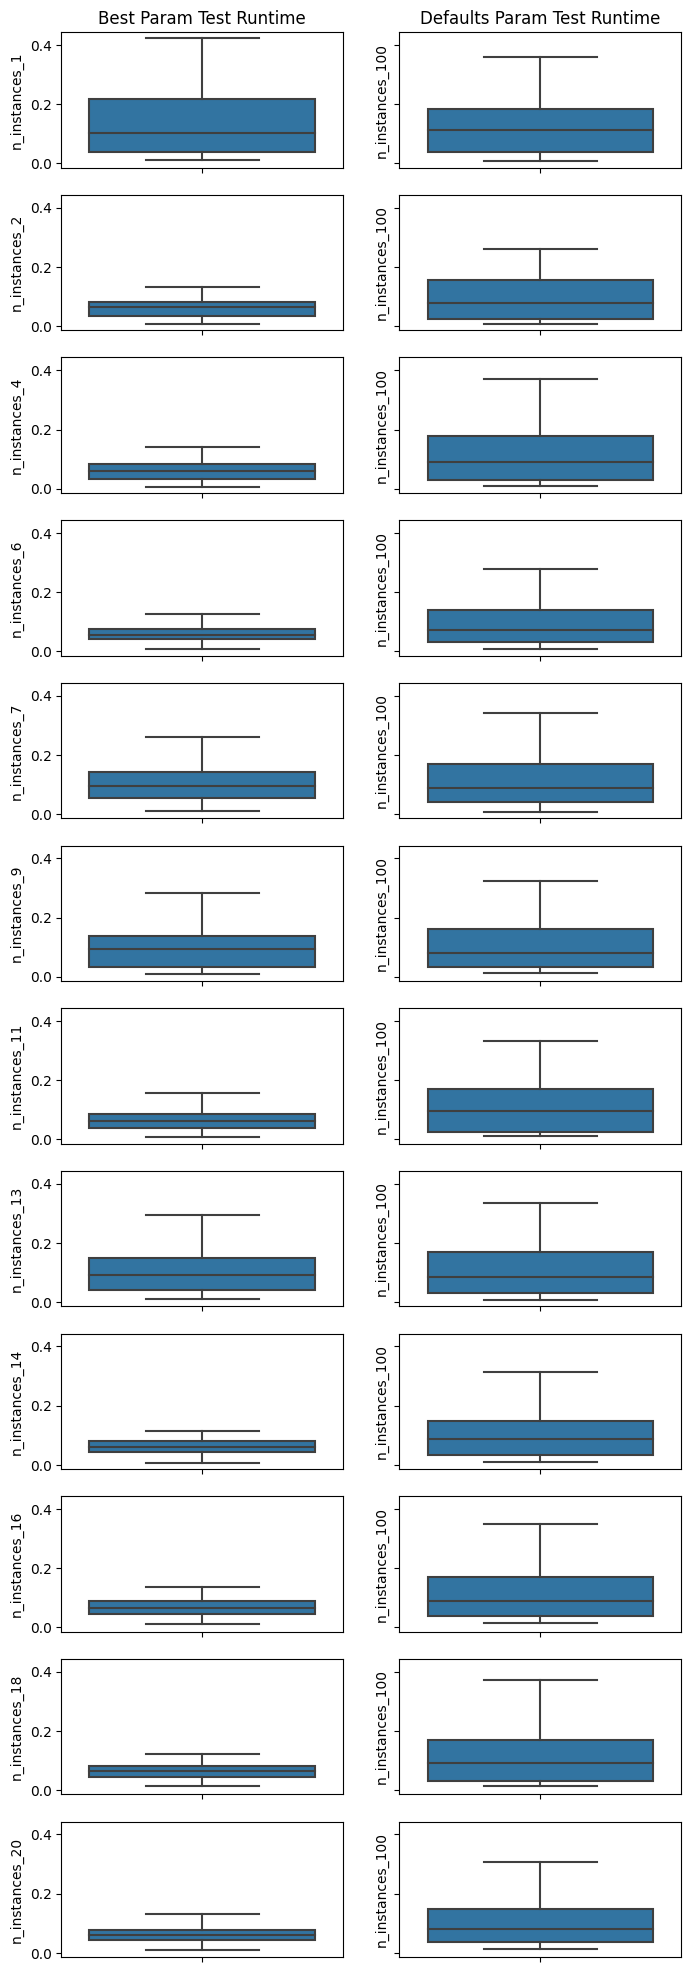

In [29]:
# Plot the test runtimes as boxplots for the best and defaults parameters across all instances
fig, axs = plt.subplots(12, 2, figsize=(8, 25), sharey=True)

for i,l in enumerate(line_instances):
  sns.boxplot(data=df_test_best, y=f'n_instances_{l}', ax=axs[i][0], showfliers=False)
  sns.boxplot(data=df_test_default, y=f'n_instances_{l}', ax=axs[i][1], showfliers=False)
  axs[i][1].set_ylabel('n_instances_100')

axs[0][0].title.set_text('Best Param Test Runtime')
axs[0][1].title.set_text('Defaults Param Test Runtime')


**Effect of Problem Difficulty**

In [18]:
# To perform this experiment, we will fix the number of training instances, so we can observe changes only in the variables we are studying
# We can leave the number of test instances high, so that we are confident in performance changes

# By default, the number of locations is 10 and the number of vehicles is 3

# We can vary these numbers at fixed intervals, observe the corresponding change in runtime, and plot the 3d manifold

In [19]:
# generate number of locations to explore
location_range=list(range(2,15,1))
print(location_range)

#generate number of vehicles to explore (minimum 2 vehicles for capacity requirement)
vehicle_range=list(range(2,10,1))
print(vehicle_range)

# generate all possible combinations
# cannot have more vehicles than locations
loc_veh_comb=[]

for l in location_range:
  for v in vehicle_range:
    if l>=v:
      loc_veh_comb.append((l,v))
    else:
      pass


# Main Loop

# initialize empty dataframe and list for plotting
df=pd.DataFrame()
location=[]
vehicle=[]
runtimes=[]
counter=1

# for each location-vehicle combination, generate training and testing instances

for l,v in loc_veh_comb:

  print('-----Starting Training Loop-----')
  print(f'Training Model {counter} / {len(loc_veh_comb)}')
  # To generate the training and testing instances, we can use the 'generate_instance_dataset' function provided by Professor Elias Khalil
  # we can use 5 training instances

  # generate training instances
  train_dataset_models, train_dataset_variables, train_dataset_coordinates = generate_instance_dataset(n_instances=3, n_locations=l, n_vehicle=v)

  # call the 'get_time_dataset' function provided by Professor Elias Khalil to get the average runtime across all instances
  rt = get_time_dataset(train_dataset_models, pars, train_dataset_variables, train_dataset_coordinates)

  # store information
  location.append(l)
  vehicle.append(v)
  runtimes.append(rt)
  counter+=1


df['location']=location
df['vehicle']=vehicle
df['runtime']=runtimes


[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
[2, 3, 4, 5, 6, 7, 8, 9]
-----Starting Training Loop-----
Training Model 1 / 76
-----Starting Training Loop-----
Training Model 2 / 76
-----Starting Training Loop-----
Training Model 3 / 76
-----Starting Training Loop-----
Training Model 4 / 76
-----Starting Training Loop-----
Training Model 5 / 76
-----Starting Training Loop-----
Training Model 6 / 76
-----Starting Training Loop-----
Training Model 7 / 76
-----Starting Training Loop-----
Training Model 8 / 76
-----Starting Training Loop-----
Training Model 9 / 76
-----Starting Training Loop-----
Training Model 10 / 76
-----Starting Training Loop-----
Training Model 11 / 76
-----Starting Training Loop-----
Training Model 12 / 76
-----Starting Training Loop-----
Training Model 13 / 76
-----Starting Training Loop-----
Training Model 14 / 76
-----Starting Training Loop-----
Training Model 15 / 76
-----Starting Training Loop-----
Training Model 16 / 76
-----Starting Training Loop-----
Training M

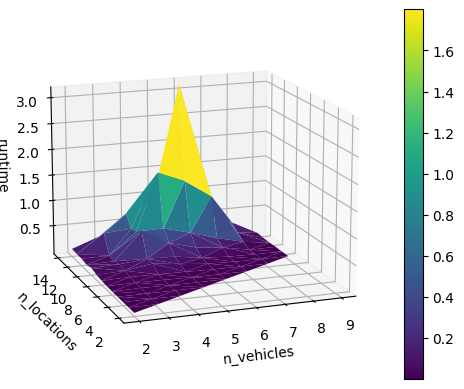

In [20]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Plot the 3D surface of location-vehicle combination and training runtimes

ax = plt.axes(projection='3d')

# Data for a three-dimensional line
z = np.array(df['runtime'])
x = np.array(df['vehicle'])
y = np.array(df['location'])

surf=ax.plot_trisurf(x, y, z, cmap='viridis', edgecolor='none')
fig.colorbar(surf)
ax.view_init(15, -110)
ax.set_ylabel('n_locations')
ax.set_xlabel('n_vehicles')
ax.set_zlabel('runtime')

plt.show()


**Tune more Gurobi Parameters**

In [21]:
# We will use the procedure Outlined in Notebook C to tune for more Gurobi Parameters
# Keep instances as 3, locations as 10 and vehicles as 3 and random forest regressor, so that we can make a fair comparison to the Notebook C

# We will add the BranchDir parameter, which controls the direction that the branch-and-cut search is explored.
# This parameter is a integer with a minvalue of -1, and a maxvalue of 1.

# We will also adjust the Presolve parameter. This parameter transforms your model into an equivalent model that is theoretically
# smaller and easier to solve. The Presolve levels include -1 (automatic), 0 (off), 1 (conservative), 2 (aggressive)

# Last we will tune the Aggregate parameter. This paramater controls the aggregation level of the presolve. It can take on the
# following integer values: 0 (off), 1 (moderate), 2 (aggressive)


In [22]:
# New parameter dictionary

params_gurobi ={
   "MIPFocus": [0,1,2,3],
   "Heuristics": [0, 0.05, 0.25, 0.5, 0.75, 1],
   "VarBranch" : [-1, 0, 1, 2, 3],
   "BranchDir" : [-1,0,1],
   "Presolve" : [-1,0,1,2],
   "Aggregate" : [0,1,2]
}

param_grid_gurobi = [ pars for pars in param_combinations(params_gurobi) ]
len(param_grid_gurobi)

4320

In [24]:
# The code below comes from Professor Elias Khalil's Notebook C

# Generate a training and a testing dataset
train_dataset_models, train_dataset_variables, train_dataset_coordinates = generate_instance_dataset(n_instances=3, n_locations=10, n_vehicle=3)
test_dataset_models, test_dataset_variables, test_dataset_coordinates = generate_instance_dataset(n_instances=3, n_locations=10, n_vehicle=3)


# Initial sampling of the parameter grid to initialize the regression model
# for model-based algorithm configuration

# Generate dataset
initial_samples = 50
data = []

for pars in random.sample(param_grid_gurobi, initial_samples):
    rt = get_time_dataset(train_dataset_models, pars, train_dataset_variables, train_dataset_coordinates)
    data += [ list(pars.values()) + [ rt ] ]

# this is the number of iterations of the configuration algorithm
evals = 10

# here, we use a random forest to predict the runtime of a configuration
regr = RandomForestRegressor(random_state = 1)

# this probability determines how frequently we will not greedily evaluate the
# configuration that is predicted to have the lowest runtime; instead, we will
# try a random configuration
exploration_probability = 0.3

best_config = -1
for eval in range(0, evals):
    # first, we fit the regression model to the current dataset;
    # the features are the parameter configurations df[:,0:-1] and the label or target
    # is the runtime df[:,-1]
    df = np.array(data)
    regr.fit(df[:,0:-1], df[:,-1])

    # perform prediction on all parameter configurations in our parameter grid
    preds = regr.predict([ list(pars.values()) for pars in param_grid_gurobi ])

    # do not explore; exploit, i.e., retrieve the best parameter configuration
    if random.random() <= 1-exploration_probability:
      i = preds.argmin()
      cur_config = list(param_grid_gurobi[i].values())
      # this if condition tracks the incumbent (i.e., best so far) configuration
      if eval == 0 or cur_config != best_config:
        best_config = cur_config
        print('New Incumbent Configuration!', cur_config)
    # explore a random configuration
    else:
      print('Exploring!')
      i = random.randint(0, len(param_grid_gurobi)-1)

    # retrieve the runtime of the selected configuration on the training dataset
    rt = get_time_dataset(train_dataset_models, param_grid_gurobi[i], train_dataset_variables, train_dataset_coordinates)

    # append the newly collected runtime data as a row to the regression dataset
    data += [ list(param_grid_gurobi[i].values()) + [ rt ] ]
    print("{}: best predicted {} for {}, actual {}."
            .format(eval, round(preds[i], 2), param_grid_gurobi[i], round(rt, 2)))

# the search has completed, so retrieve the configuration that has recorded
# the lowest runtime in the dataset we have collected
i = np.array(data)[:,-1].argmin()
print("Best runtime ({}) for parameters {}.".format(data[i][-1], data[i][0:-1]))

# test that best configuration on the test dataset of VRP instances
rt_test = get_time_dataset(test_dataset_models, {'MIPFocus': data[i][0],
                                                                    'Heuristics': data[i][1],
                                                                    'VarBranch': data[i][2],
                                                                    'BranchDir': data[i][3],
                                                                    'Presolve' : data[i][4],
                                                                    'Aggregate' : data[i][5]}, test_dataset_variables, test_dataset_coordinates)
print("Test performance: {}".format((rt_test)))


[[1, 0.25, 2, 0, 0, 0, 0.07756336530049641], [1, 0.25, -1, -1, 0, 1, 0.08365766207377116], [2, 0.5, -1, -1, 0, 2, 0.13672367731730142], [3, 1, -1, -1, 0, 1, 0.2533098856608073], [1, 0.25, 2, 0, -1, 0, 0.07278402646382649], [1, 0.25, 2, 1, -1, 2, 0.07501562436421712], [3, 0.05, 0, 0, 0, 0, 0.18517939249674478], [0, 1, -1, -1, 1, 1, 0.03621832529703776], [2, 0.25, 3, -1, 1, 2, 0.16617695490519205], [2, 0, 0, -1, 2, 2, 0.10548933347066243], [1, 0.25, -1, 0, 2, 1, 0.08079202969868977], [0, 0, -1, 0, 2, 0, 0.07858959833780925], [3, 0.75, 3, 0, 1, 1, 0.22951801617940268], [2, 0.05, 3, -1, -1, 0, 0.1577005386352539], [2, 1, 1, -1, 0, 0, 0.20511500040690103], [2, 1, 1, 1, 0, 2, 0.18026932080586752], [3, 0, 0, 1, 2, 2, 0.44072802861531574], [0, 0.25, 3, 0, 0, 1, 0.10463770230611165], [2, 0.25, 1, -1, 0, 2, 0.14052669207255045], [2, 0.5, 0, 0, 0, 1, 0.12762864430745444], [1, 0, -1, 1, -1, 0, 0.04122201601664225], [1, 1, 2, 1, 2, 1, 0.0964210033416748], [2, 0, -1, 1, 1, 2, 0.07928760846455891], [

**Modify the Alogirithm Configuration**

In [25]:
# Methodology

# We can try a variety of different ML models: Random Forest, Linear Regression and Support Vector Regressor
# In order to take advantage of uncertainty in prediction, we can calculate a broostrapped prediction interval (95%) for each of the predictions.
# For each prediction, we can check to see which has the largest interval--a proxy for model uncertainty at that point
# We can then choose to exlpore the parameter configuration that has the highest prediction interval
# This should make the exploration informative, rather than arbitary

# We can increase the training instances slightly, since a higher number of instances tends to increase the ability of the model to generalize (while also increasing training time)
# However, since we want to properly compare it to part 1, we will keep n_locations=10 and n_vehicles=3

# We can increase the test instances to a higher number so we have more confidence in our results

# The total number of parameter combinations is 4320.
# Let's increase the initial_sample size to 200
# Let's increase the number of evals to 40

In [26]:
# Define bootstrapping uncertainty method
# This function returns the bootstrapped prediction interval for all parameter configurations

def bootstrap_prediction_interval(model, df_train , X_new, n_bootstraps=10):
  '''
  Parameters
  model = model to use for predictions
  df_train = training data
  X_new = prediction interval to be boostrapped
  n_bootstraps = number of times to perform bootstrap

  Returns
  975th percentile confidence interval on predictions
  2.5th percentile lower bound on predictions

  '''

  # Begin bootstrap procedure
  for b in range(n_bootstraps):
    idxs = np.random.choice(range(len(df_train)), size = len(df_train), replace = True) #sample with replacement
    model.fit(df_train.iloc[idxs, :-1],df_train.iloc[idxs,-1]) #fit current model
    predictions = model.predict(X_new).reshape(1,-1) #predict on all parameter configurations
    if b == 0:
      preds = predictions
    else:
      preds = np.vstack((preds, predictions))

  # # Find the 95% confidence interval details
  uncertainty_idx = np.argmax((pd.DataFrame(preds).quantile(q=0.975, axis=0))-(pd.DataFrame(preds).quantile(q=0.025, axis=0)))
  uncertainty_value = max((pd.DataFrame(preds).quantile(q=0.975, axis=0))-(pd.DataFrame(preds).quantile(q=0.025, axis=0)))
  return uncertainty_idx, uncertainty_value

In [30]:
# The code below comes from Professor Elias Khalil's Notebook C

# Generate a training and a testing datasets
train_dataset_models, train_dataset_variables, train_dataset_coordinates = generate_instance_dataset(n_instances=5, n_locations=10, n_vehicle=3)
test_dataset_models, test_dataset_variables, test_dataset_coordinates = generate_instance_dataset(n_instances=500, n_locations=10, n_vehicle=3)

# Initial sampling of the parameter grid to initialize the regression model
# for model-based algorithm configuration

initial_samples = 200
data = []

for pars in random.sample(param_grid_gurobi, initial_samples):
    rt = get_time_dataset(train_dataset_models, pars, train_dataset_variables, train_dataset_coordinates)
    data += [ list(pars.values()) + [ rt ] ]


# Define results dataframe
df_results=pd.DataFrame(columns=['RF_pred','LR_pred','SVR_pred','RF_act','LR_act','SVR_act','RF_cl','LR_cl','SVR_cl'])

# Number of bootstraps
# a general rule for number of bootstraps is sqrt() of dataset size
# however, since dataset is small, will increase to 70% of data
n_bootstraps=140



# The code below is adapted from Professor Elias Khalil's Notebook C
best_config=-1
best_runtime=-1
exploit_counter=0

model_list = [RandomForestRegressor(n_estimators=50, max_depth=20), LinearRegression(fit_intercept=True), SVR(kernel='rbf', degree=3, C=2)]

# Number of times to evaluate new regression solution
evals = 40

for m, regr in enumerate(model_list):
  pred_runtimes=[]
  actual_runtimes=[]
  pred_uncertainty=[]
  rmse=[]
  df_train=pd.DataFrame(data, columns=['MIPFocus','Heuristics','VarBranch','BarnchDir','Presolve','Aggregate','runtime']) # Re-initialize training dataframe with original data

  for eval in range(0, evals):
  # Define model and fit model
    model = regr
    model.fit(df_train.iloc[:,:-1],df_train.iloc[:,-1])

    # Make predictions on trained model
    # Get best predicted parameters with current model
    X_new=[list(pars.values()) for pars in param_grid_gurobi]
    original_preds= model.predict(X_new)

    best_pred_rt=min(original_preds)
    pred_runtimes.append(best_pred_rt)

    i_original=original_preds.argmin()
    cur_config = list(param_grid_gurobi[i_original].values())
    cur_runtime = get_time_dataset(train_dataset_models, param_grid_gurobi[i_original], train_dataset_variables, train_dataset_coordinates)
    actual_runtimes.append(cur_runtime)


    if eval == 0 or cur_runtime <=best_runtime:
      best_runtime = cur_runtime
      print('New Best Runtime', best_runtime)
      best_config = cur_config
      print('New Incumbent Configuration!', cur_config)


    # Bootstrap the predictions and get the parameters with the lowest runtime value on the 95% confidence interval
    uncertainty_idx, uncertainty_value = bootstrap_prediction_interval(model,df_train, X_new, n_bootstraps)
    pred_uncertainty.append(uncertainty_value)

    # Exploit if unseen
    if all((cur_config==p).all()==False for p in np.array(df_train.iloc[:,:-1]))==True:  # current config is not already in training data
      print('Exploit current configuration')
      print(f'Adding Current Parameters: {cur_config}')
      # add current parameter configuration to the training data
      data_temp = [ cur_config + [cur_runtime]]
      df_temp = pd.DataFrame(data_temp, columns=['MIPFocus','Heuristics','VarBranch','BarnchDir','Presolve','Aggregate','runtime'])
      df_train = pd.concat([df_train, df_temp])

    # Explore
    print('Exploring Bootstrapped Parameters with most uncertain runtime')
    # add this parameter conrfiguration to the training data
    bootstrap_config = list(param_grid_gurobi[uncertainty_idx].values())
    print(f'Adding Bootstrapped Parameters: {bootstrap_config}')
    rt_bootstrap = get_time_dataset(train_dataset_models, param_grid_gurobi[uncertainty_idx], train_dataset_variables, train_dataset_coordinates)
    # add parameters to training dataset
    data_temp = [bootstrap_config + [ rt_bootstrap ] ]
    df_temp = pd.DataFrame(data_temp, columns=['MIPFocus','Heuristics','VarBranch','BarnchDir','Presolve','Aggregate','runtime'])
    df_train = pd.concat([df_train, df_temp])

    # calculate RMSE
    rmse.append(mean_squared_error(actual_runtimes, pred_runtimes, squared=False))

  # the search has completed, so retrieve the configuration that has recorded
  # the lowest runtime in the dataset we have collected
  i_best = np.argmin(df_train['runtime'])
  print("Best runtime ({}) for parameters {}.".format(df_train.iloc[i_best, -1], df_train.iloc[i_best, :-1]))

  # test the best configuration on the test dataset of VRP instances
  rt_test = get_time_dataset(test_dataset_models, {'MIPFocus': df_train.iloc[i_best, 0],
                                                                      'Heuristics': df_train.iloc[i_best, 1],
                                                                      'VarBranch': df_train.iloc[i_best, 2],
                                                                      'BranchDir': df_train.iloc[i_best, 3],
                                                                      'Presolve' : df_train.iloc[i_best, 4],
                                                                      'Aggregate' : df_train.iloc[i_best, 5]}, test_dataset_variables, test_dataset_coordinates)
  print("Test performance: {}".format((rt_test)))

  # test the best configuration on the test dataset of VRP instances (descriptive)
  rt_test_descriptive=get_time_dataset_descriptive(test_dataset_models, {'MIPFocus': df_train.iloc[i_best, 0],
                                                                      'Heuristics': df_train.iloc[i_best, 1],
                                                                      'VarBranch': df_train.iloc[i_best, 2],
                                                                      'BranchDir': df_train.iloc[i_best, 3],
                                                                      'Presolve' : df_train.iloc[i_best, 4],
                                                                      'Aggregate' : df_train.iloc[i_best, 5]}, test_dataset_variables, test_dataset_coordinates)

  # Save results
  if m==0:
    df_results['RF_pred']=pred_runtimes
    df_results['RF_act']=actual_runtimes
    df_results['RF_cl']=pred_uncertainty
    df_results['RF_rmse']=rmse
    RF_test_rt=rt_test_descriptive
  elif m==1:
    df_results['LR_pred']=pred_runtimes
    df_results['LR_act']=actual_runtimes
    df_results['LR_cl']=pred_uncertainty
    df_results['LR_rmse']=rmse
    LR_test_rt=rt_test_descriptive
  else:
    df_results['SVR_pred']=pred_runtimes
    df_results['SVR_act']=actual_runtimes
    df_results['SVR_cl']=pred_uncertainty
    df_results['SVR_rmse']=rmse
    SVR_test_rt=rt_test_descriptive

New Best Runtime 0.05630962053934733
New Incumbent Configuration! [1, 0, 1, 1, 2, 1]
Exploring Bootstrapped Parameters with most uncertain runtime
Adding Bootstrapped Parameters: [3, 0.5, 2, 0, 2, 1]
Exploit current configuration
Adding Current Parameters: [1, 0, 1, 1, 0, 1]
Exploring Bootstrapped Parameters with most uncertain runtime
Adding Bootstrapped Parameters: [3, 0.05, 1, 0, -1, 0]
Exploit current configuration
Adding Current Parameters: [1, 0, 1, 1, 2, 2]
Exploring Bootstrapped Parameters with most uncertain runtime
Adding Bootstrapped Parameters: [3, 0.5, 2, 0, 2, 1]
Exploring Bootstrapped Parameters with most uncertain runtime
Adding Bootstrapped Parameters: [3, 0.05, 1, 0, -1, 0]
Exploring Bootstrapped Parameters with most uncertain runtime
Adding Bootstrapped Parameters: [3, 0.25, -1, 1, -1, 0]
New Best Runtime 0.05239725112915039
New Incumbent Configuration! [1, 0, 1, 1, 2, 2]
Exploring Bootstrapped Parameters with most uncertain runtime
Adding Bootstrapped Parameters: [3

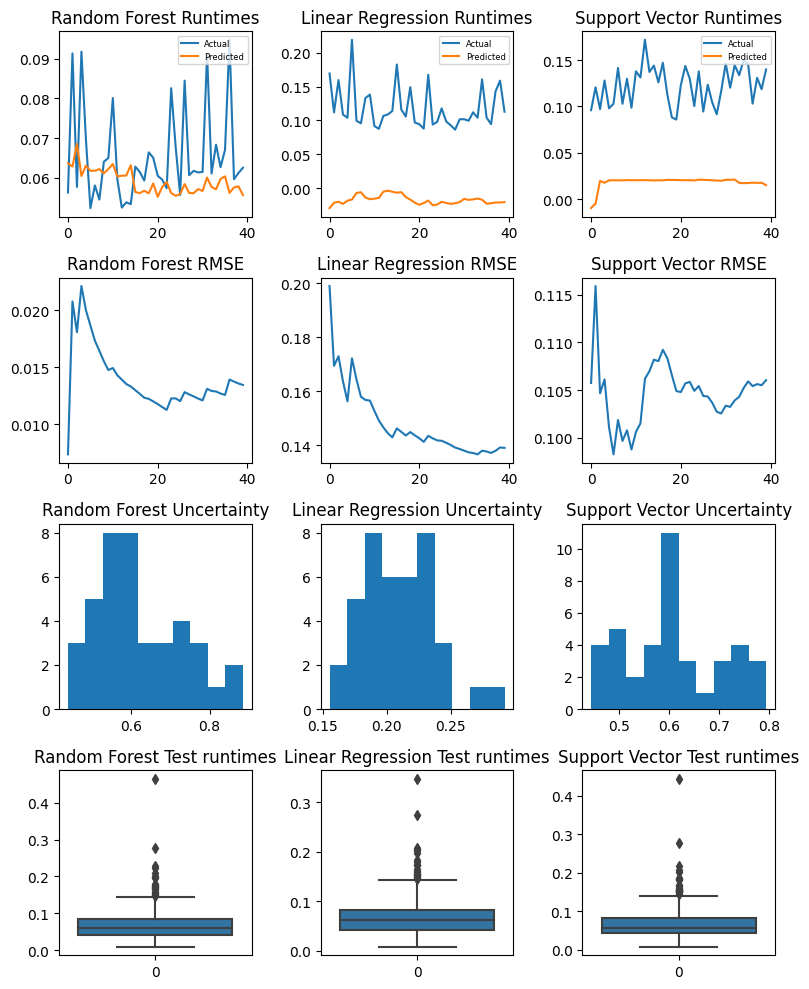

In [31]:
# Plot the results
# Graph 1: runtime plots (predicted & actual)
# Graph 2: RMSE vs iteration plots
# Graph 3: histogram of largest prediction interval
# Graph 4: Boxplot distributions of test runtimes

fig, axs = plt.subplots(4, 3, figsize=(8, 10), sharey=False)

# Runtime Plots
axs[0][0].plot(df_results['RF_act'], label='Actual')
axs[0][0].plot(df_results['RF_pred'], label='Predicted')
axs[0][0].legend(loc="upper right", prop={'size': 6})
axs[0][0].set_title(label="Random Forest Runtimes")

axs[0][1].plot(df_results['LR_act'], label='Actual')
axs[0][1].plot(df_results['LR_pred'], label='Predicted')
axs[0][1].legend(loc="upper right", prop={'size': 6})
axs[0][1].set_title(label="Linear Regression Runtimes")

axs[0][2].plot(df_results['SVR_act'], label='Actual')
axs[0][2].plot(df_results['SVR_pred'], label='Predicted')
axs[0][2].legend(loc="upper right", prop={'size': 6})
axs[0][2].set_title(label="Support Vector Runtimes")
# RMSE Plots

axs[1][0].plot(df_results['RF_rmse'])
axs[1][0].set_title(label='Random Forest RMSE')

axs[1][1].plot(df_results['LR_rmse'])
axs[1][1].set_title(label='Linear Regression RMSE')

axs[1][2].plot(df_results['SVR_rmse'])
axs[1][2].set_title(label='Support Vector RMSE')

# Uncertainty Distributions
axs[2][0].hist(x=df_results['RF_cl'])
axs[2][0].set_title(label='Random Forest Uncertainty')

axs[2][1].hist(x=df_results['LR_cl'])
axs[2][1].set_title(label='Linear Regression Uncertainty')

axs[2][2].hist(x=df_results['SVR_cl'])
axs[2][2].set_title(label='Support Vector Uncertainty')

# Test Result Boxplots
sns.boxplot(data=RF_test_rt, ax=axs[3][0], showfliers=True)
axs[3][0].set_title(label='Random Forest Test runtimes')

sns.boxplot(data=LR_test_rt, ax=axs[3][1], showfliers=True)
axs[3][1].set_title(label='Linear Regression Test runtimes')

sns.boxplot(data=SVR_test_rt, ax=axs[3][2], showfliers=True)
axs[3][2].set_title(label='Support Vector Test runtimes')

fig.tight_layout()

plt.show()
